In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [3]:
def plot_the_loss_curve(epochs, mse_training, mse_validation):

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.plot(epochs[0:], mse_training[0:], label="Training Loss")
  plt.plot(epochs[0:], mse_validation[0:], label="Validation Loss")
  plt.legend()
  
  # We're not going to plot the first epoch, since the loss on the first epoch
  # is often substantially greater than the loss for other epochs.
  merged_mse_lists = mse_training[1:] + mse_validation[1:]
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
   
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show() 

In [4]:
l_min = 1
l_max = 1

n_l = 1  # defined only one value for L, for now.

# q in kN
q_min = 100
q_max = 200

n_q = 10

# E in GPa
E_min = 210
E_max = 300

n_E = 10

# I in dm^4
I_min = 1 * 10 ** 3 
I_max = 1.5 * 10 ** 3

n_I = 10

# Will make the vectors linearly spaced, but it's not necessary
l_vec = np.linspace(l_min, l_max, n_l)
q_vec = np.linspace(q_min, q_max, n_q)
E_vec = np.linspace(E_min, E_max, n_E)
I_vec = np.linspace(I_min, I_max, n_I)

In [5]:
# Compute all possible permutations and arrange them in a matrix

per_list = []
for i in range(len(l_vec)):
    for j in range(len(q_vec)):
        for k in range(len(E_vec)):
            for l in range(len(I_vec)):
                per_list = np.append(per_list, np.array([[l_vec[i], q_vec[j], E_vec[k], I_vec[l]]]))

per_list = per_list.reshape(-1, 4)

# Shuffle the permutations
np.random.shuffle(per_list)

np.save('125_combinations', per_list)  # saved as an .npy file to use later using np.load('125_combinations')

In [6]:
# analytical solution for the beam bending problem

def ana_sol(n, param_list):
    l=param_list[0]
    q=param_list[1]
    E=param_list[2]
    I=param_list[3]
    x_min = 0
    x_max = l
    x = np.linspace(x_min, x_max, n)
    y = np.zeros(len(x))
    c_1 = -(q * 10 ** 3 * l ** 3) / (24 * E * 10 ** 9 * I * 10 ** (-8))
    y = (1 / (E * 10 ** 9 * I * 10 ** (-8))) * (((q * 10 ** 3 * l) / 12) * x ** 3 - (q * 10 ** 3 / 24) * x ** 4) + c_1 * x

    return [x, y]

def ana_sol_with_noise(n, param_list,noise):
    l=param_list[0]
    q=param_list[1]
    E=param_list[2]
    I=param_list[3]
    x_min = 0
    x_max = l
    x = np.linspace(x_min, x_max, n)
    y = np.zeros(len(x))
    c_1 = -(q * 10 ** 3 * l ** 3) / (24 * E * 10 ** 9 * I * 10 ** (-8))
    y = (1 / (E * 10 ** 9 * I * 10 ** (-8))) * (((q * 10 ** 3 * l) / 12) * x ** 3 - (q * 10 ** 3 / 24) * x ** 4) + c_1 * x
    y = y + noise * (np.random.random(len(y)) - 0.5) * (np.max(y) - np.min(y))

    return [x, y]

In [7]:
#alternative way to generate fake data with noise
n = 1000
# Add noise
noise_factor = 0.2
#create dictionary with generated data
fake_data = {}
#dict keys: list of parameters values
#dict values: (x,y) array 
for i in per_list:
    fake_data[repr(i.tolist())] = ana_sol_with_noise(n, i, noise_factor)

In [8]:
#for each entry combination of (l,q,E,I) we have two columns of fake data: both x and noisy y 
fake_dataframe=pd.DataFrame.from_dict(fake_data,orient='index',columns=['x', 'y'])
#I will now dstructure the data in such a way that we are able to immediatly assess 
# which entry combination of (l,q,E,I) gives a specific (x,Y)
#let's clean a little
fake_dataframe=fake_dataframe.rename_axis('parameters').reset_index()
fake_dataframe.parameters=[eval(fake_dataframe.parameters[i]) for i in range(len(fake_dataframe))]
fake_dataframe[['l','q','E','I']] = pd.DataFrame(fake_dataframe.parameters.tolist(), index= fake_dataframe.index)
fake_dataframe=fake_dataframe.drop(columns='parameters')
#let's see an example of structured data
fake_dataframe

,x,y,l,q,E,I
0,"[0.0, 0.001001001001001001, 0.0020020020020020...","[-3.397440876891834e-05, -2.285000368285243e-0...",1.0,122.222222,290.0,1166.666667
1,"[0.0, 0.001001001001001001, 0.0020020020020020...","[2.4817512140715158e-05, -1.4565085861002302e-...",1.0,122.222222,250.0,1333.333333
2,"[0.0, 0.001001001001001001, 0.0020020020020020...","[1.8797637588449878e-05, 2.0314156446367863e-0...",1.0,166.666667,230.0,1222.222222
3,"[0.0, 0.001001001001001001, 0.0020020020020020...","[4.2987025222002784e-05, -4.174034051106114e-0...",1.0,122.222222,230.0,1277.777778
4,"[0.0, 0.001001001001001001, 0.0020020020020020...","[2.8173244474467057e-05, -3.344234121238589e-0...",1.0,111.111111,230.0,1000.000000
...,...,...,...,...,...,...
995,"[0.0, 0.001001001001001001, 0.0020020020020020...","[3.5214321128670434e-05, -3.000603790334237e-0...",1.0,111.111111,270.0,1166.666667
996,"[0.0, 0.001001001001001001, 0.0020020020020020...","[7.088425150930636e-05, 3.992665497252798e-05,...",1.0,177.777778,210.0,1444.444444
997,"[0.0, 0.001001001001001001, 0.0020020020020020...","[4.125262784723587e-05, -5.1938889910108375e-0...",1.0,177.777778,220.0,1055.555556
998,"[0.0, 0.001001001001001001, 0.0020020020020020...","[-8.507897296360323e-06, -4.905670511652647e-0...",1.0,155.555556,240.0,1055.555556


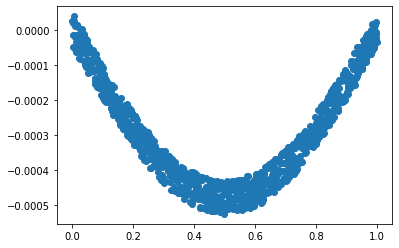

In [9]:
#plot the 1st entry of the dataframe
plt.scatter(fake_dataframe['x'][1],fake_dataframe['y'][1],label=str(fake_dataframe.index[1]))
plt.show()

In [10]:
#with the dataset organized is much easier to split the data.
#https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test
#let's take a look at an example 
test_split=0.1 #we will use 10% of the data for testing. 
df = fake_dataframe
train_df, test_df = train_test_split(df, test_size = test_split)

In [11]:
#the training data will be spllited automatically by 80/20 during training using keras framework. 
# no need to split at this stage.
#let's check the array shapes: 
print('Training set: ',train_df.shape)
print('Test set: ',test_df.shape)

train_size = train_df.shape[0]
test_size = test_df.shape[0]

Training set:  (900, 6)
Test set:  (100, 6)


C:\Users\luisf\.conda\envs\tf\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


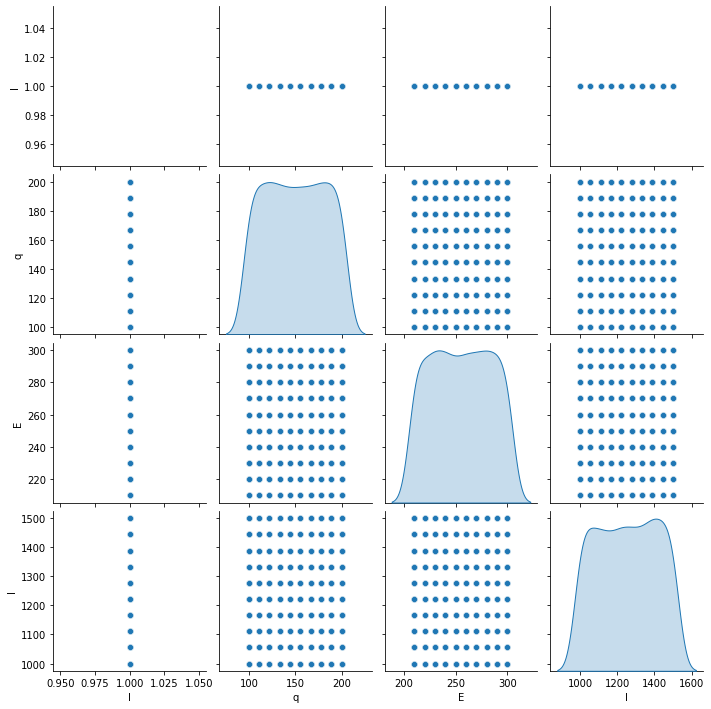

In [12]:
#inspect the training dataset
sns.pairplot(train_df[['l', 'q', 'E', 'I']], diag_kind='kde')

In [13]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
l,900.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.0
q,900.0,149.987654,31.914772,100.0,122.222222,150.000000,177.777778,200.0
E,900.0,254.922222,28.567866,210.0,230.000000,260.000000,280.000000,300.0
I,900.0,1251.728395,160.358614,1000.0,1111.111111,1277.777778,1388.888889,1500.0


In [14]:
# follow this tutorial for our data 
# https://www.tensorflow.org/tutorials/keras/regression
# whenever possible, add comments and discussion

In [15]:
# get the max "y" for each entry
df.y.apply(min)
# at this point we could plot very interesting stuff such as ymax distributions on the vars (q,l,E,I)...
# but let's think about that later

0     -0.000516
1     -0.000525
2     -0.000848
3     -0.000595
4     -0.000686
         ...   
995   -0.000504
996   -0.000836
997   -0.001093
998   -0.000875
999   -0.000889
Name: y, Length: 1000, dtype: float64

In [16]:
# I have fixed the value of L as 1.0 for now, so I am not using the values of [x,y] as inputs, only the values of y.

In [17]:
# Allocate the features and the labels in different DataFrames.

train_features = train_df.copy()
test_features = test_df.copy()

# train_labels = pd.DataFrame([train_features.pop('l'), train_features.pop('q'), train_features.pop('E'), train_features.pop('I')])
# train_labels = train_labels.T
# test_labels = pd.DataFrame([test_features.pop('l'), test_features.pop('q'), test_features.pop('E'), test_features.pop('I')])
# test_labels = test_labels.T

train_labels = pd.DataFrame([train_features.pop('q'), train_features.pop('E'), train_features.pop('I')])
train_labels = train_labels.T
test_labels = pd.DataFrame([test_features.pop('q'), test_features.pop('E'), test_features.pop('I')])
test_labels = test_labels.T

In [18]:
feature_columns = []

# Will not include the values of x
# x_col = tf.feature_column.numeric_column("x")
# feature_columns.append(x_col)
y_col = tf.feature_column.numeric_column("y")
feature_columns.append(y_col)

my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [19]:
# Build the model and define its architecture.

In [20]:
inputs = keras.Input(shape=n)

In [21]:
dense = layers.Dense(512, activation="relu")
x = dense(inputs)

In [22]:
x = layers.Dense(512, activation="relu")(x)
outputs = layers.Dense(3)(x)

In [23]:
model = keras.Model(inputs=inputs, outputs=outputs, name="model")

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
dense (Dense)                (None, 512)               512512    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1539      
Total params: 776,707
Trainable params: 776,707
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Set the hyperparameters

validation_split=0.2
learning_rate = 0.01
batch_size = 50
epochs = 20

In [26]:
model.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
)

# Still need to find what's the best loss function for our model.

In [27]:
# For some reason I had to manually convert the data into tensors.

tf_train_features = tf.constant([train_features['y']], shape=(train_size,n))

tf_train_labels = tf.constant([np.array(train_labels)], shape=(train_size,3))

tf_test_features = tf.constant([test_features['y']], shape=(test_size,n))

tf_test_labels = tf.constant([np.array(test_labels)], shape=(test_size,3))

In [28]:
history = model.fit(tf_train_features, tf_train_labels, batch_size=batch_size, epochs=epochs, validation_split=validation_split)

test_scores = model.evaluate(tf_train_features, tf_train_labels, verbose=2)
print("Test loss:", test_scores)

Epoch 1/20
15/15 [==============================] - 1s 35ms/step - loss: 538276.1875 - val_loss: 427840.6250
Epoch 2/20
15/15 [==============================] - 0s 16ms/step - loss: 254586.1719 - val_loss: 52095.2109
Epoch 3/20
15/15 [==============================] - 0s 16ms/step - loss: 36088.0898 - val_loss: 28123.6582
Epoch 4/20
15/15 [==============================] - 0s 16ms/step - loss: 21952.7520 - val_loss: 18923.8027
Epoch 5/20
15/15 [==============================] - 0s 15ms/step - loss: 16541.7715 - val_loss: 14907.2246
Epoch 6/20
15/15 [==============================] - 0s 14ms/step - loss: 14589.6143 - val_loss: 13659.3086
Epoch 7/20
15/15 [==============================] - 0s 15ms/step - loss: 13324.4541 - val_loss: 13574.2031
Epoch 8/20
15/15 [==============================] - 0s 15ms/step - loss: 12358.0156 - val_loss: 11796.3350
Epoch 9/20
15/15 [==============================] - 0s 15ms/step - loss: 11570.9072 - val_loss: 11267.3379
Epoch 10/20
15/15 [===============

247525.845703125


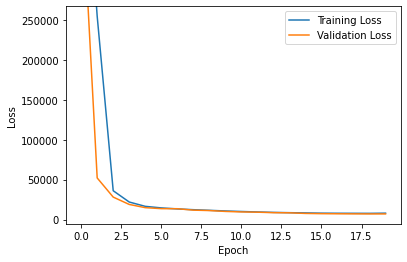

In [29]:
epochs = history.epoch

hist = history.history

plot_the_loss_curve(epochs, hist["loss"], 
                    hist["val_loss"])

In [30]:
tf_test_labels[0:5]

# q; E; I

<tf.Tensor: shape=(5, 3), dtype=float64, numpy=
array([[ 155.55555556,  300.        , 1444.44444444],
       [ 166.66666667,  270.        , 1055.55555556],
       [ 122.22222222,  230.        , 1444.44444444],
       [ 100.        ,  280.        , 1000.        ],
       [ 155.55555556,  220.        , 1000.        ]])>

In [31]:
model.predict(tf_test_features)[0:5]

# q; E; I

array([[ 158.8179 ,  269.25943, 1318.5646 ],
       [ 146.74341,  248.77284, 1218.1139 ],
       [ 158.25204,  268.29938, 1313.8575 ],
       [ 158.75516,  269.15298, 1318.043  ],
       [ 140.07695,  237.46193, 1162.6527 ]], dtype=float32)

In [32]:
# relative error (%)

(np.abs(tf_test_labels[0:5] - model.predict(tf_test_features)[0:5]) / tf_test_labels[0:5]) * 100

<tf.Tensor: shape=(5, 3), dtype=float64, numpy=
array([[ 2.09722246, 10.24685669,  8.71476018],
       [11.95395508,  7.86191022, 15.40026341],
       [29.47894565, 16.65190324,  9.04063157],
       [58.75515747,  3.87393406, 31.80429687],
       [ 9.9505321 ,  7.9372406 , 16.265271  ]])>

In [33]:
error_mat = (np.abs(tf_test_labels - model.predict(tf_test_features)) / tf_test_labels) * 100

error_avg = np.array([0,0,0])
error_avg[0] = np.average(error_mat[:,0])
error_avg[1] = np.average(error_mat[:,1])
error_avg[2] = np.average(error_mat[:,2])

error_avg

# average relative error (%) for [q, E, I]

array([23,  9,  9])

In [34]:
def compare_curves(label, guess, n):

    label = [1, label[0], label[1],label[2]]
    guess = [1, guess[0], guess[1], guess[2]]
    
    x_vec = np.linspace(0, 1, n)
    y_vec = ana_sol(n, label)[1] * 10**3  # [mm]

    points = np.zeros((len(x_vec), 2))

    for i in range(len(x_vec)):
        points[i, 0] = x_vec[i]
        points[i, 1] = y_vec[i]
    
    y_vec_g = ana_sol(n, guess)[1] * 10**3  # [mm]

    points = np.zeros((len(x_vec), 2))

    for i in range(len(x_vec)):
        points[i, 0] = x_vec[i]
        points[i, 1] = y_vec[i]


    plt.plot(x_vec, y_vec, c='g')
    plt.plot(x_vec, y_vec_g, c='r')
    plt.show()

In [35]:
# error_col will contain the average of the relative errors (%) for q, E and I for each guess.

error_col = (error_mat[:,0] + error_mat[:,1] + error_mat[:,2])/3

error_col[0:10]

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([ 7.01961311, 11.73870957, 18.39049348, 31.47779614, 11.3843479 ,
        9.11514479, 15.61700022, 15.90186927, 26.47475561,  9.69087493])>

In [36]:
np.min(error_col)

2.4952045890855454

In [37]:
# Relative errors (%) for q, E, I for our best curve.
np.array(error_mat[np.argmin(error_col),:])

array([0.65047782, 6.42585754, 0.40927841])

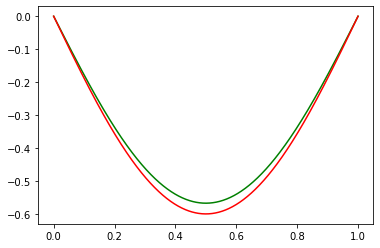

In [38]:
# This is the best guess (the guess which as the minimum average error)
# "True" curve is in green, whereas the "guessed" curve is in red.

min_label = np.array(tf_test_labels[np.argmin(error_col),:])
min_guess = model.predict(tf_test_features)[np.argmin(error_col),:]

compare_curves(min_label, min_guess, n)

In [39]:
np.max(error_col)

34.14220954047309

In [40]:
# Relative errors (%) for q, E, I for our worst curve.
np.array(error_mat[np.argmax(error_col),:])

array([60.00663757,  9.57454427, 32.84544678])

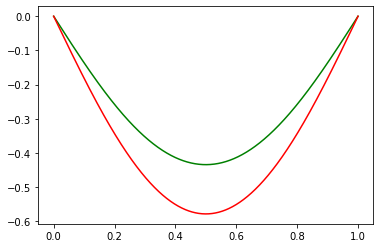

In [41]:
# This is the worst guess (the guess which as the maximum average error)
# "True" curve is in green, whereas the "guessed" curve is in red.

max_label = tf_test_labels[np.argmax(error_col),:]
max_guess = model.predict(tf_test_features)[np.argmax(error_col),:]

compare_curves(max_label, max_guess, n)

The errors for q, E and I (%) are: [ 0.02856328 16.63924444  7.93987183]


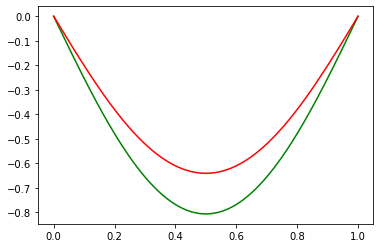

In [42]:
# The curve with less error for q.
i_min_q = np.argmin(error_mat, axis=0)[0]

print('The errors for q, E and I (%) are:', np.array(error_mat[i_min_q,:]))

min_q_label = tf_test_labels[i_min_q,:]
min_q_guess = model.predict(tf_test_features)[i_min_q ,:]

compare_curves(min_q_label, min_q_guess, n)

The errors for q, E and I (%) are: [11.67980957  0.1807312   4.73557478]


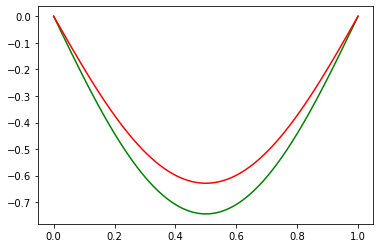

In [43]:
# The curve with less error for E.
i_min_E = np.argmin(error_mat, axis=0)[1]

print('The errors for q, E and I (%) are:', np.array(error_mat[i_min_E,:]))

min_E_label = tf_test_labels[i_min_E,:]
min_E_guess = model.predict(tf_test_features)[i_min_E ,:]

compare_curves(min_E_label, min_E_guess, n)

The errors for q, E and I (%) are: [60.47654724 18.29288649  0.0727356 ]


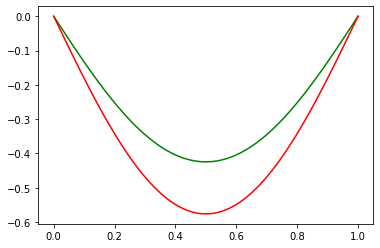

In [44]:
# The curve with less error for I.
i_min_I = np.argmin(error_mat, axis=0)[2]

print('The errors for q, E and I (%) are:', np.array(error_mat[i_min_I,:]))

min_I_label = tf_test_labels[i_min_I,:]
min_I_guess = model.predict(tf_test_features)[i_min_I ,:]

compare_curves(min_I_label, min_I_guess, n)

In [45]:
# 07/08/2021

# There is no point in trying to guess L in this case, as there is only one value for it.

# Even for multiple values of L, I think that it doesn't make sense to have [x, y] as inputs and at the same time try to 
# guess L, at least in the way I was innitially doing, because, (as the x values are linnearly spaced and allways the same
# for each L), we could easily check the max value of x and get L from that, without any need for a machine learning method.

In [46]:
# 07/08/2021

# Need to improve the way I feed the data to the model (had to extract it from DataFrames and convert the arrays to tensors...)

# Will try to figure out the best loss function, the best architecture for the model,
# tune the hyperparameters and try to get good results.

In [47]:
# 12/09/2021

# I am now only trying to find 3 parameters: E, q and I, as L was set to 1.0.

# After some tunning and experimenting, I'm still not able to say if the problem is with the architecture
# of the model being still too simple, if the problem is with the loss function or if it has to due with
# the lack of normalization of the features. I've noticed that the model is very bad at guessing
# the values for I, which are very small.

In [48]:
# 18/09/2021

# Adjusted the units of q, E and I. This way the values of the loss function don't get too high, they were
# often turning into NaN when I tryed to adjust the model or increase the number of [x,y] inputs.
# This way it is also easier to read the resuts.